DC Resistivity: 1D Resistivity Inversion
========================================

In this notebook, we:
- load Schlumberger sounding data from a text file
- plot the raw apparent resistivity data as a function of electrode separation
- assign uncertainties to the data
- recover an electrical resistivity model for a specified number of layers
- plot the recovered resistivity model and compare observed and predicted data

Import Modules
----------------------

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from discretize import TensorMesh

from SimPEG import (maps, data, data_misfit, regularization,
    optimization, inverse_problem, inversion, directives
    )
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.StaticUtils import plot_layer
from SimPEG.utils import mkvc

User Defined Paramters for the Notebook
-----------------

Here, the user defines paramters required to run the notebook. These parameters are as follows:
- **data_filename:** The file path to a csv file containing the sounding data
- **half_AB_column:** The column in the csv file that has the AB/2 values.
- **half_MN_column:** The column in the csv file that has the MN/2 values.
- **apparent_resistivity_column:** The column in the csv file that has the apparent resistivity values.


- **uncertainty_column:** The column in the csv file that has the uncertainty, or the keyword `None`.
- **uncertainty_floor:** The floor uncertainty to be added to each datum
- **uncertainty_percent:** The percent uncertainty to be added to each datum
- **chi_factor:** Controls how closely we fit the data in the inversion.


- **layer_thicknesses:** Layer thicknesses in meters. Defined from top layer to bottom

In [2]:
# Define the file path to the data file. Also define the AB/2, MN/2 and apparent resistivity columns.
# Recall that python counts starting at 0
data_filename = './assets/Mawlamyaing_data_locations_3.csv'
half_AB_column = 'AB/2 (m)'
half_MN_column = 'MN/2 (m)'
apparent_resistivity_column = 'App. Res. (Ohm m)'

# Define the uncertainties for the inversion.
# Either use the uncertainty from the data file,
uncertainty_column = None
# or define the floor and percent uncertainty you would like to apply to apparent resistivity data
uncertainty_floor = 5.
uncertainty_percent = 5.
chi_factor = 1.0


# Define layer thicknesses as a numpy array
# layer_thicknesses = mkvc(np.r_[5*np.ones(15), 5*np.logspace(0,1,15)])
layer_thicknesses = (5*1.1**np.arange(21))

Load Data, Define Survey and Plot
---------------------------------

Here we load the observed data, define the DC survey geometry and plot the
data values.

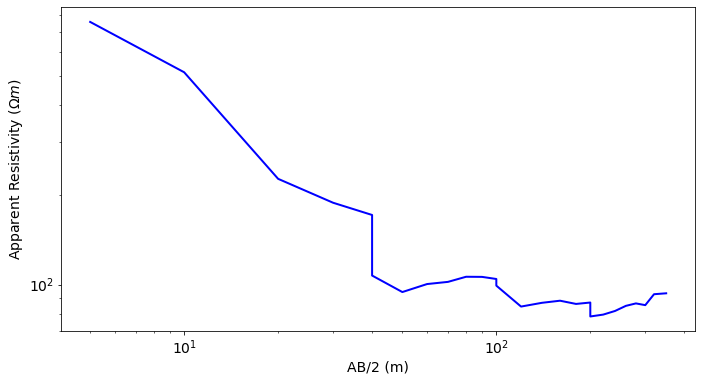

In [3]:
# Load data
df = pd.read_csv(data_filename)

# Extract source and receiver electrode locations and the observed data
half_AB_separations = df[half_AB_column]
half_MN_separations = df[half_MN_column]
dobs = df[apparent_resistivity_column].values

starting_resistivity = np.median(dobs)

# Define survey
unique_tx, k = np.unique(half_AB_separations, return_index=True)
n_sources = len(k)
k = np.sort(k)
k = np.r_[k, len(dobs)+1]

source_list = []
for ii in range(0, n_sources):
    
    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = -half_MN_separations[k[ii]:k[ii+1]]
    M_locations = np.c_[M_locations, np.zeros((np.shape(M_locations)[0], 2))]
    N_locations = half_MN_separations[k[ii]:k[ii+1]]
    N_locations = np.c_[N_locations, np.zeros((np.shape(N_locations)[0], 2))]
    receiver_list = [dc.receivers.Dipole(M_locations, N_locations)]
    
    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-half_AB_separations[k[ii]], 0., 0.]
    B_location = np.r_[half_AB_separations[k[ii]], 0., 0.]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

# Compute the A, B, M and N electrode locations.
survey.getABMN_locations()

# Plot apparent resistivities on sounding curve as a function of Wenner separation
# parameter.
electrode_separations = np.sqrt(
        np.sum((survey.m_locations - survey.n_locations)**2, axis=1)
        )

mpl.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
ax1.loglog(half_AB_separations, dobs, 'b', lw=2)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
plt.show()

Assign Uncertainties
--------------------

Inversion with SimPEG requires that we define uncertainties on our data. The
uncertainty represents our estimate of the standard deviation of the noise on
our data.

In [4]:
if uncertainty_column is not None:
    uncertainties = df[uncertainty_column].values
else:
    uncertainties = uncertainty_floor + 0.01*uncertainty_percent*np.abs(dobs)

Define Data
--------------------

Here is where we define the data that are inverted. The data are defined by
the survey, the observation values and the uncertainties.

In [5]:
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

Define a Starting and Reference Model
-------------------------------------

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is log(1000) Ohm meters.

Define log-resistivity values for each layer since our model is the
log-resistivity. Don't make the values 0!
Otherwise the gradient for the 1st iteration is zero and the inversion will
not converge.

In [6]:
# Defines layered Earth
mesh = TensorMesh([layer_thicknesses], '0')

# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(starting_resistivity*np.ones((len(layer_thicknesses))))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(mesh)*maps.ExpMap()

Define the Physics
------------------

Here we define the physics of the problem using the DCSimulation_1D class.


In [7]:
simulation = dc.simulation_1d.DCSimulation_1D(
        survey=survey, rhoMap=model_map, thicknesses=layer_thicknesses[:-1],
        data_type="apparent_resistivity"
        )

Define Inverse Problem
----------------------

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem



In [8]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Simple(
    mesh, alpha_s=1e-3, alpha_x=1., mref=starting_model
)

# Create model weights based on sensitivity matrix (sensitivity weighting). This is
# done to counteract the inversion's desire to place structures only at regions
# of very high sensitivity.
# wr = np.sum(simulation.getJ(starting_model)**2, axis=0)**0.5
# wr = (wr/np.max(np.abs(wr)))
# reg.cell_weights = wr  # include in regularization

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(
    maxIter=30, maxIterCG=20, print_type='ubc'
)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

Define Inversion Directives
---------------------------

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.



In [9]:
starting_resistivity

94.005

In [10]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2., coolingRate=1.)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    starting_beta, beta_schedule,
    save_iteration, target_misfit
]

Running the Inversion
---------------------

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [ ]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2020-02-01-22-02.npz'
model has any nan: 0
=================================== Inexact Gauss Newton ===================================
  #     beta     phi_d     phi_m     phi_s     phi_x     phi_y     phi_z    LS    Comment   
--------------------------------------------------------------------------------------------
   0  4.38e+01  5.88e+02  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00   0              
   1  2.19e+01  2.23e+02  1.33e+00  3.39e-03  1.33e+00  0.00e+00  0.00e+00   0              
   2  1.10e+01  8.49e+01  3.79e+00  4.86e-03  3.79e+00  0.00e+00  0.00e+00   0              
   3  5.48e+00  4.61e+01  5.67e+00  5.76e-03  5.67e+00  0.00e+00  0.00e+00   0   Skip BFGS  
   4  2.74e+00  3.53e+01  6.95e+00  6.22e-03  6.95e+00 

In [ ]:
# Inversion result from Mon DRD
res_tmp = np.array([348.4, 722.9, 282, 100.8, 51.4, 170.8, 31.1, 184.3])
thick_tmp = np.array([1.4, 1.6, 1.4, 12.1, 11.4, 25.1, 54.2])
plotting_mesh_tmp = TensorMesh([np.r_[thick_tmp, 200]], '0')

Examining the Results
---------------------



In [ ]:
# Plot true model and recovered model
fig = plt.figure(figsize=(5, 5))
mpl.rcParams.update({'font.size': 14})
x_min = np.min(model_map*recovered_model)
x_max = np.max(model_map*recovered_model)

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_layer(model_map*recovered_model, mesh, ax=ax1, depth_axis=False)
ax1.set_ylim(-300, 0)
ax1.set_xlim(10, 5000)
ax1.grid(True, which='both', ls="--", c='gray')


# Plot the true and apparent resistivities on a sounding curve
from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(7, 5))
mpl.rcParams.update({'font.size': 14})
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
ax1.loglog(half_AB_separations, inv_prob.dpred, 'k', lw=2)
ax1.loglog(half_AB_separations, dobs, 'kx', lw=2, ms=10)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
ax1.legend(['Observed Sounding Curve','Predicted Sounding Curve'])
ax1.set_ylim(50, 1000)
ax1.grid(True, which='both', ls="--", c='gray')
plt.show()

In [ ]:
# Plot true model and recovered model
fig = plt.figure(figsize=(5, 5))
mpl.rcParams.update({'font.size': 14})
x_min = np.min(model_map*recovered_model)
x_max = np.max(model_map*recovered_model)

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_layer(model_map*recovered_model, mesh, ax=ax1, depth_axis=False)
plot_layer(res_tmp, plotting_mesh_tmp, ax=ax1, depth_axis=False, color='r')
ax1.legend(("SimPEG", "Mon State DRD"))
ax1.grid(True, which='both', ls="--", c='gray')
ax1.set_ylim(-300, 0)
ax1.set_xlim(10, 5000)

In [ ]:
n_interation = len(save_iteration.outDict)
phi_d = np.zeros(n_interation)
phi_m = np.zeros(n_interation)

for ii in range(1,n_interation+1):
    phi_d[ii-1] = save_iteration.outDict[ii]['phi_d']
    phi_m[ii-1] = save_iteration.outDict[ii]['phi_m']

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(np.arange(n_interation)+1, phi_d, 'ko-')
ax_1 = ax[0].twinx()
ax_1.plot(np.arange(n_interation)+1, phi_m, 'ro-')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\phi_d$", fontsize = 20)
ax_1.set_ylabel("$\phi_m$", fontsize = 20, color='r')


ax[1].plot(phi_m, phi_d, 'ko-')
ax[1].set_ylabel("$\phi_d$", fontsize = 20)
ax[1].set_xlabel("$\phi_m$", fontsize = 20)
plt.tight_layout()